# Topic modelling with Gensim

In this notebook Gensim is used to find topics from the documents, we first study coherence measures to find the number of topics in the collection, then we visualize results.

The basic idea is to study the differences between topics in different times. So we first present the methodology followed given an era, and then perform the study on all eras.

In [1]:
import sys
sys.path.append("..")

from src.dataset import Dataset

# utils
import json
import random 
import numpy as np
from collections import defaultdict
from threading import Thread
# topic modelling
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel, LdaMulticore, LdaModel

# visualization
from pprint import pprint
import matplotlib.pyplot as plt
import pyLDAvis
from pyLDAvis import gensim_models

In [2]:
import warnings
warnings.filterwarnings('ignore')

/home/fran/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Loading the tokenized documents

In [3]:
dataset = Dataset()
# load only the year specified
year = None # carico solo quel ventennio 
# year = 1860 # carico solo quel ventennio 

# tokens = dataset.load_dataset(year=year, tokens=True)
tokens = dataset.load_dataset(year=year, tokens=True)

In [4]:
len(tokens)

183146

In [6]:
freq = defaultdict(lambda:0)
for doc in tokens:
    for w in doc:
    # for w in set(doc):        
        freq[w] += 1

In [7]:
narcotics = ['cannabis', 'cocaine', 'methamphetamine', 'drugs', 'drug', 'marijuana', 
             'ecstasy', 'lsd', 'ketamine', 'heroin', 'fentanyl', 'overdose']

weapons = ['gun', 'knife', 'weapon', 'firearm', 'rifle', 'carabine', 'shotgun', 'handgun', 
           'revolver', 'musket', 'pistol', 'derringer', 'assault', 'rifle', 'sword', 'blunt']

investigation = ['gang', 'mafia', 'serial',  'killer', 'rape', 'theft', 'recidivism', 
                 'arrest', 'robbery', 'cybercrime', 'cyber', 'crime']

interesting_set = set(narcotics + weapons + investigation)

In [8]:
def sel_criterium(w):
    return (w in interesting_set) or ((len(w) >= 3) and (10 < freq[w] < 0.5*len(tokens)))

tokens = [[w for w in doc if sel_criterium(w)] for doc in tokens]

### Sampling data

In [14]:
num_samples = 5
sample_size = 1000
samples = []
for i in range(num_samples):
    samples.append(random.sample(tokens, sample_size))

### Creating required structures
The topic modelling requires this three structures to work, the first one gives a mapping from an id to a word, 
second one is the tokenized collection, and the third one is a list for each document of word id, frequency.

In [10]:
def create_structures(texts):
    id2word = corpora.Dictionary(texts)
    corpus = [id2word.doc2bow(text) for text in texts]
    return id2word, corpus

### Fitting LDA models and computing coherence measures

Lda is unsupervised, a crucial parameter is the number of topics to find in the collection. To avoid choosing at random one could compute the coherence measure given a certain number of topics and pick the highest coherence.

To do so, different models are fitted, and the best one, according to coherence is considered.

In [11]:
def compute_coherence_perplexity_values(tokens, k=[2,3,4], verbose=True):
    
    id2word, corpus = create_structures(sample)
    
    lda_models = []
    statistics = []
    
    for topics in k:
        if verbose: print(f"Fitting model with {topics} topics.")
        lda_model = LdaModel(corpus=corpus, id2word=id2word, num_topics=topics, 
                             random_state=100, update_every=1, chunksize=100,
                             passes=100, alpha='auto', per_word_topics=True)
        
        lda_models.append(lda_model)
        coherence_model = CoherenceModel(model=lda_model, texts=tokens, 
                                             dictionary=id2word, coherence='c_v')
        
        statistics.append({"topics" : topics, 
                          "coherence" : coherence_model.get_coherence(),
                          "log_perplexity" : lda_model.log_perplexity(corpus)})
        
    return lda_models, statistics

In [16]:
k = range(3, 9)
# stats = []

for i, sample in enumerate(samples):
    print(f"Processing {i} sample")
    _, statistics = compute_coherence_perplexity_values(samples[i], k, verbose=False)
    stats.append(statistics)

Processing 0 sample
Processing 1 sample
Processing 2 sample
Processing 3 sample
Processing 4 sample


### Plotting coherence measures
The best model is the one with four topics.

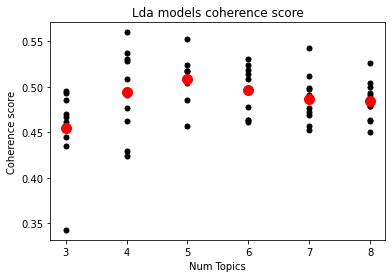

In [36]:
coherences = [[x["coherence"] for x in el] for el in stats]

means = [np.mean([coherences[i][j] for i in range(len(coherences))]) 
         for j in range(len(coherences[0]))]

for c in coherences:
    plt.plot(k, c, "o", color="black", markersize=5)
    
plt.plot(k, means, "o", color="red", markersize=10)

plt.title("Lda models coherence score")
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
# plt.legend(([f"{i}th sample" for i in range(len(coherences))] + ["mean"]), loc='best')
plt.show()

In [ ]:
# best, ind = max(zip(statistics, range(len(statistics))), key=lambda x:(x[0]["coherence"], x[1]))
# print(f"Best model found:\n{best}")
# best_model = lda_models[ind]
# print("\nBest model topics:")
# best_model.print_topics()

### pyLDAvis visualization

This tool offers a graphical visualization of the topics, a good visualization has big topics that are far from each others.

In [ ]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(best_model, corpus, id2word)
vis

## NOT FOR NOW Putting all together

After presenting the methodology, we run different searches on each era to find the best number of topics, the result is a model for each era that achieved the bet coherence.

In [ ]:
tokens_dir = "../data/processed/tokens"
models_dir = "../data/models/lda"
epochs_files = [f"{tokens_dir}/{f}" for f in sorted(os.listdir(tokens_dir))]

min_topics = 8
max_topics = 13

k = range(min_topics, max_topics+1)

best_models = {}
for epoch in epochs_files:
    # extracting year name
    name = int(epoch.split("/")[-1].split(".")[0])
    print(f"Computing best model for {name}:")
    
    # creating required structures
    texts = json.load(open(epoch, "r"))
    id2word = corpora.Dictionary(texts)
    corpus = [id2word.doc2bow(text) for text in texts]
    
    # fitting models and picking the best one
    lda_models, statistics = compute_coherence_perplexity_values(corpus, id2word, texts, k, verbose=False)
    best, ind = max(zip(statistics, range(len(statistics))), key=lambda x:x[0]["coherence"])
    print(f"\tBest one: {best}\n")
    best_models[name] = lda_models[ind]
    
    # saving model to disk
    os.makedirs(f"{models_dir}/{name}")
    lda_models[ind].save(f"{models_dir}/{name}/{name}_lda.model")